In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, r2_score, roc_auc_score
from TreeModelsFromScratch.DecisionTree import DecisionTree
from TreeModelsFromScratch.RandomForest import RandomForest
from TreeModelsFromScratch.SmoothShap import verify_shap_model, smooth_shap, GridSearchCV_scratch, cross_val_score_scratch
from TreeModelsFromScratch.datasets import DATASETS_CLASSIFICATION, DATASETS_REGRESSION, DATASET_PATH
from imodels.util.data_util import get_clean_dataset
import os
from datetime import datetime
import pickle
from tqdm import tqdm

In [4]:
#for storing results
data_path = os.path.join(os.path.dirname(os.getcwd()),"data","SHAP_dis_experiment")

# Experiment Distribution of SHAP values

In [41]:
def create_shap_summary_comparison(index_dataset, n_estimators=100, treetype="classification", cv=3, random_state=42):
    
    if treetype=="classification":
        mtry = "sqrt"
        dataset = DATASETS_CLASSIFICATION
        scoring_func = roc_auc_score
    else:
        mtry = 1/3
        dataset = DATASETS_REGRESSION
        scoring_func = r2_score
        
    grid = {"HS_lambda":[0.1,1,10,25,50,100]}
    
    #Load dataset
    dset_name, dset_file, data_source = dataset[index_dataset]
    X, y, feat_names = get_clean_dataset(dset_file, data_source, DATASET_PATH)
    
    results = {"simulation_settings":
            {"n_estimators":n_estimators,
            "treetype": treetype,
            "cv": cv,
            "random_state": random_state},
        "data":{"X":X,
                "y":y,
                "dset_name": dset_name,
                "feat_names": feat_names},
        "RF":{
            "model": None,
            "grid_cv": None,
            "SHAP_vals": None},
        "HsRF":{
            "model": None,
            "grid_cv": None,
            "SHAP_vals": None},
        "AufHsRF_smSHAP":{
            "model": None,
            "grid_cv": None,
            "SHAP_vals": None},
        "AufHsRF_MSE":{
            "model": None,
            "grid_cv": None,
            "SHAP_vals": None}}
    
    # Create list of models
    model_list = []
    model_names = ["RF", "HsRF", "AufHsRF_smSHAP", "AufHsRF_MSE"]
    
    #RF
    model_list.append(RandomForest(n_trees=n_estimators, n_feature=mtry, treetype=treetype, random_state=random_state))
    #HS
    model_list.append(RandomForest(n_trees=n_estimators, n_feature=mtry, treetype=treetype, random_state=random_state, HShrinkage=True))
    #AugHsRF smSHAP
    model_list.append(RandomForest(n_trees=n_estimators, n_feature=mtry, treetype=treetype, random_state=random_state, 
                                   oob_SHAP=True, HS_smSHAP=True))
    #AugHsRF MSE
    model_list.append(RandomForest(n_trees=n_estimators, n_feature=mtry, treetype=treetype, random_state=random_state, 
                                   HS_nodewise_shrink_type="MSE_ratio"))
 
    for i, model in enumerate(tqdm(model_list)):
        
        # NO GridSearch for RF model
        if i ==0:
            model.fit(X,y)
        else:
            grid_cv = GridSearchCV_scratch(model, grid, X, y, cv=cv, scoring_func=scoring_func)
            results[model_names[i]]["grid_cv"] = grid_cv
        
        results[model_names[i]]["model"]=model
        export_model = model.export_forest_for_SHAP()
        explainer = shap.TreeExplainer(export_model)
        results[model_names[i]]["SHAP_vals"]= explainer.shap_values(X)
        
    with open(f'{data_path}/{dset_name}_SHAP_dis.pickle', 'wb') as handle:
        pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
    return results


In [58]:
def create_comp_plot(results, max_display=10):
    
    model_names = ["RF", "HsRF", "AufHsRF_smSHAP", "AufHsRF_MSE"]
    model_names_plot = ["RF", "HsRF", "AufHsRF smSHAP", "AufHsRF MSE"]
    X = results["data"]["X"]
    feat_names = results["data"]["feat_names"]
    dset_name = results["data"]["dset_name"]
    
    # Create plot
    fig = plt.figure()
    
    for i, model in enumerate(model_names):
        
        ax = fig.add_subplot(int(f"22{i+1}"))
        ax.set_title(model_names_plot[i])
        shap.summary_plot(results[model_names[i]]["SHAP_vals"], X, feature_names=feat_names, max_display=max_display, show=False)
    
    plt.gcf().set_size_inches(20,10)
    plt.suptitle(f"{dset_name}", fontsize=14)
    plt.tight_layout() 
    plt.show()
    
    # Save figure
    fig.savefig(f"{data_path}/{dset_name}_plots.png")
    
    return fig

## Classification datasets

In [69]:
# Run experiment for all clf datasets
clf_num = [1,2,3,5,6]
for i in clf_num:
    create_shap_summary_comparison(i, n_estimators=100, treetype="classification", cv=3, random_state=42)

100%|██████████| 4/4 [1:14:58<00:00, 1124.62s/it]


In [70]:
# Load pickeled results
clf_names = ["heart","breast-cancer","haberman","diabetes","german-credit"]
results={}

for name in clf_names:
    # load pickeled resutls
    with open(f'{data_path}/{name}_SHAP_dis.pickle', "rb") as input_file:
        results[name]=pickle.load(input_file)

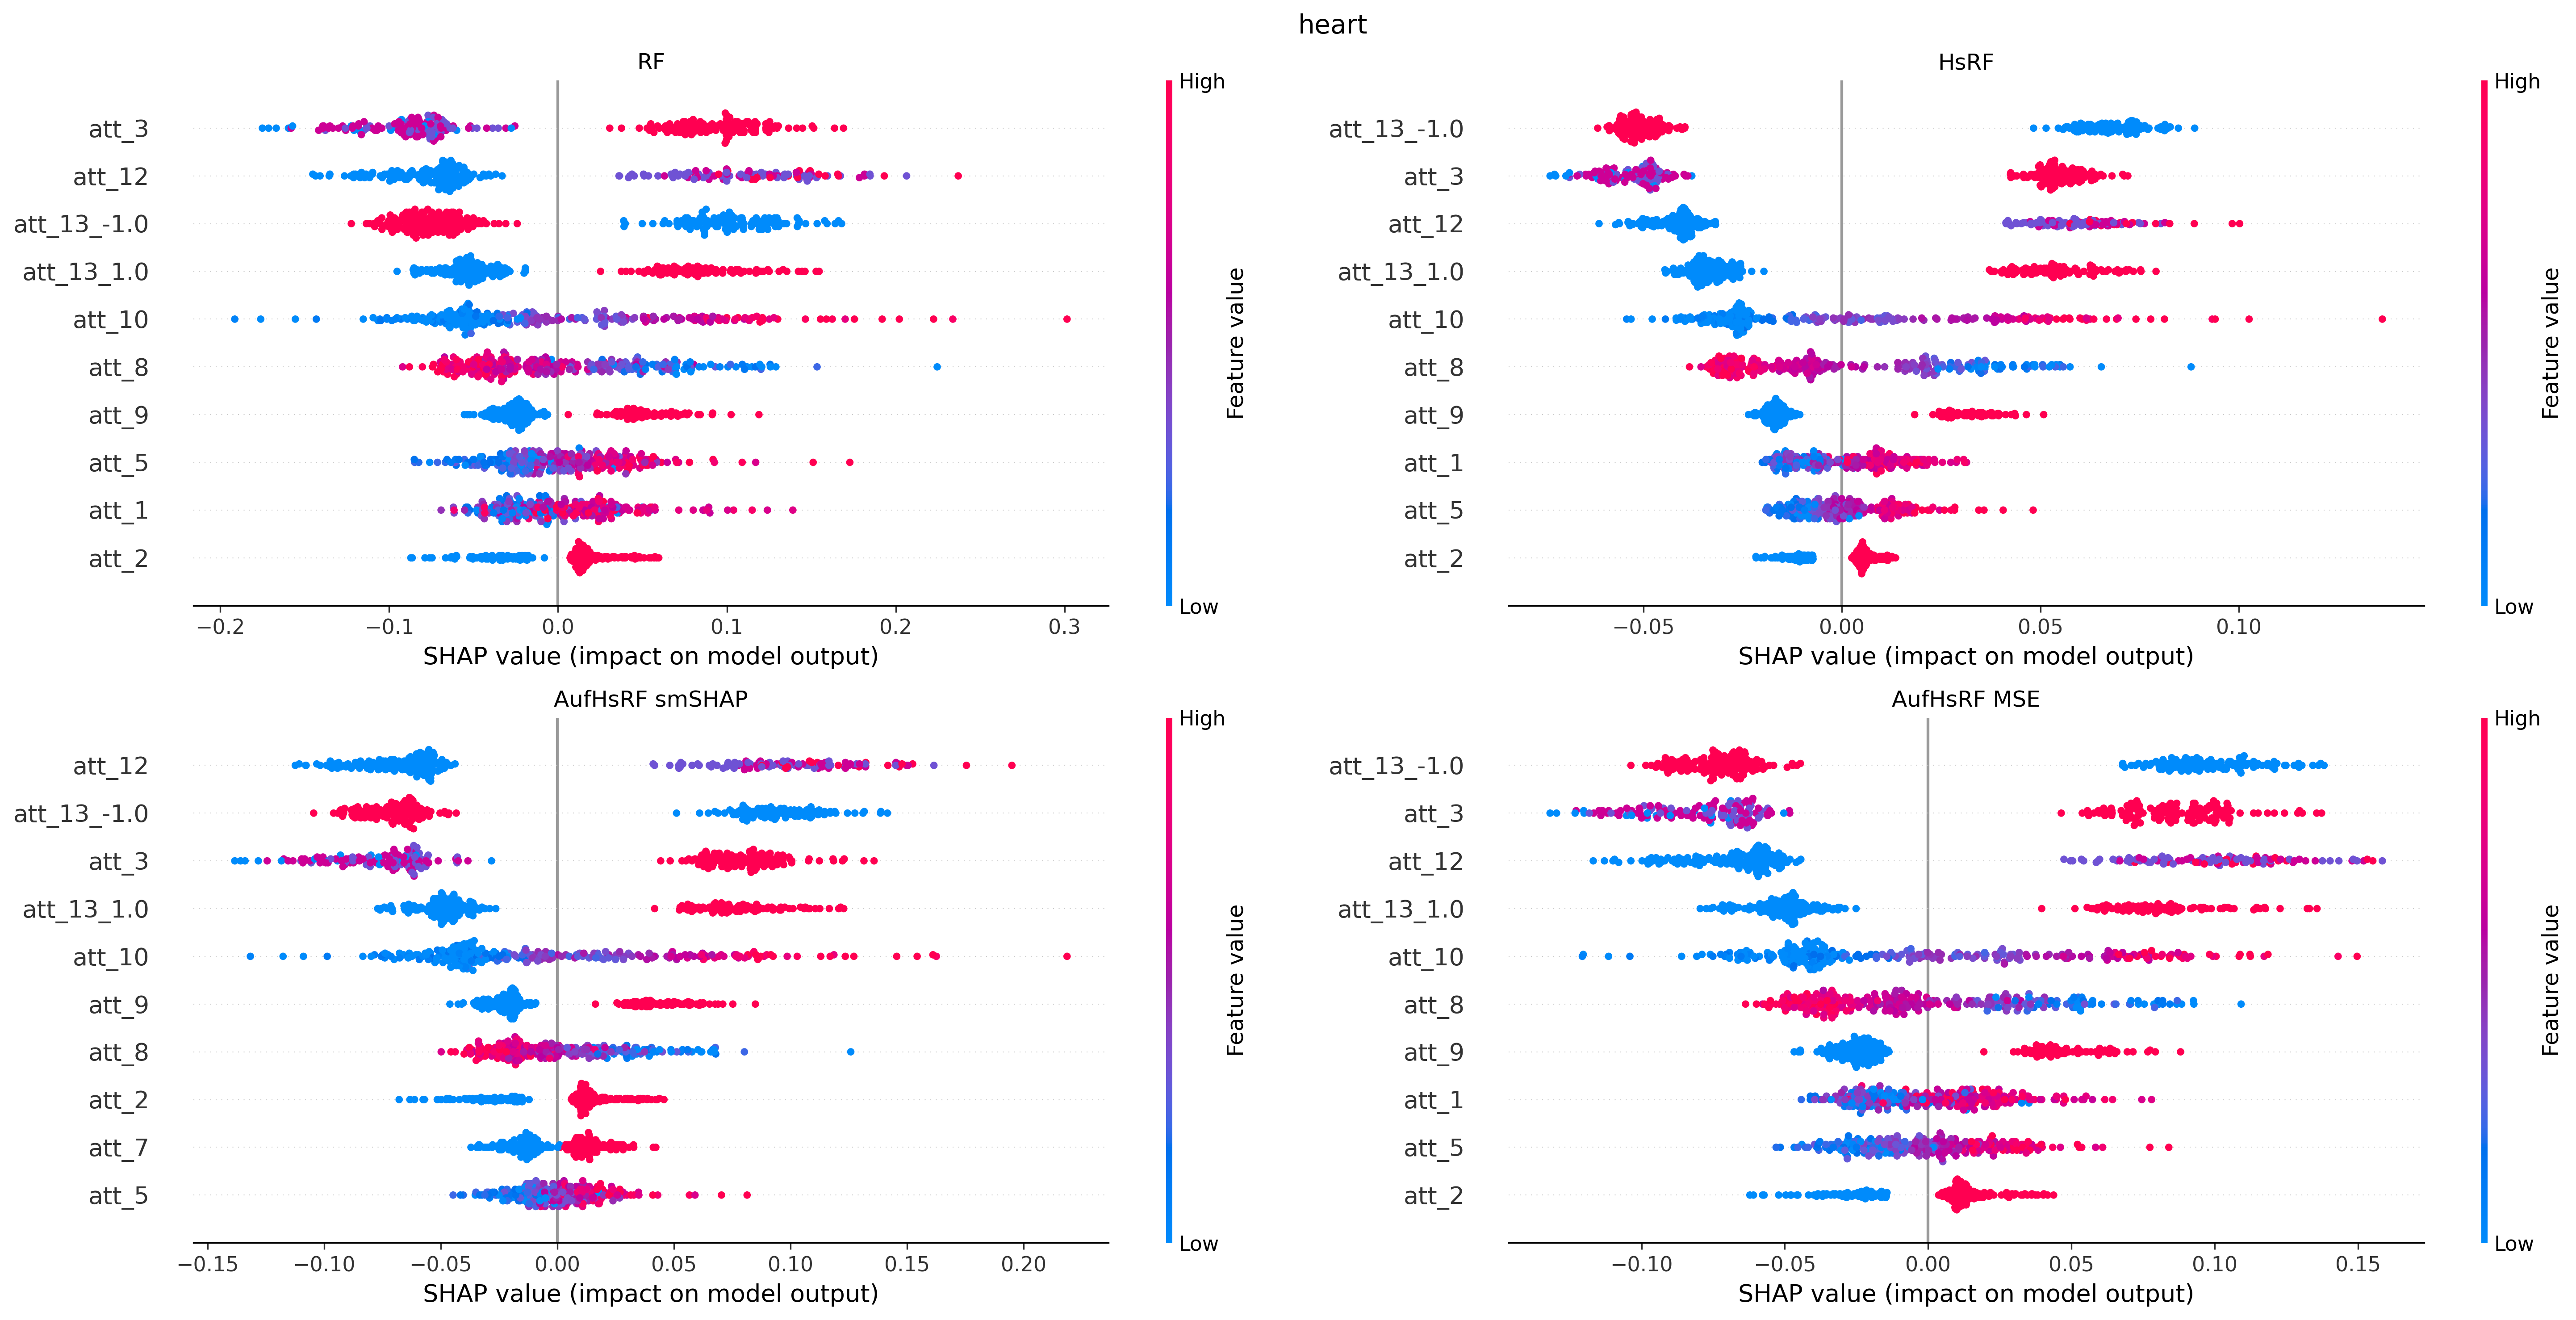

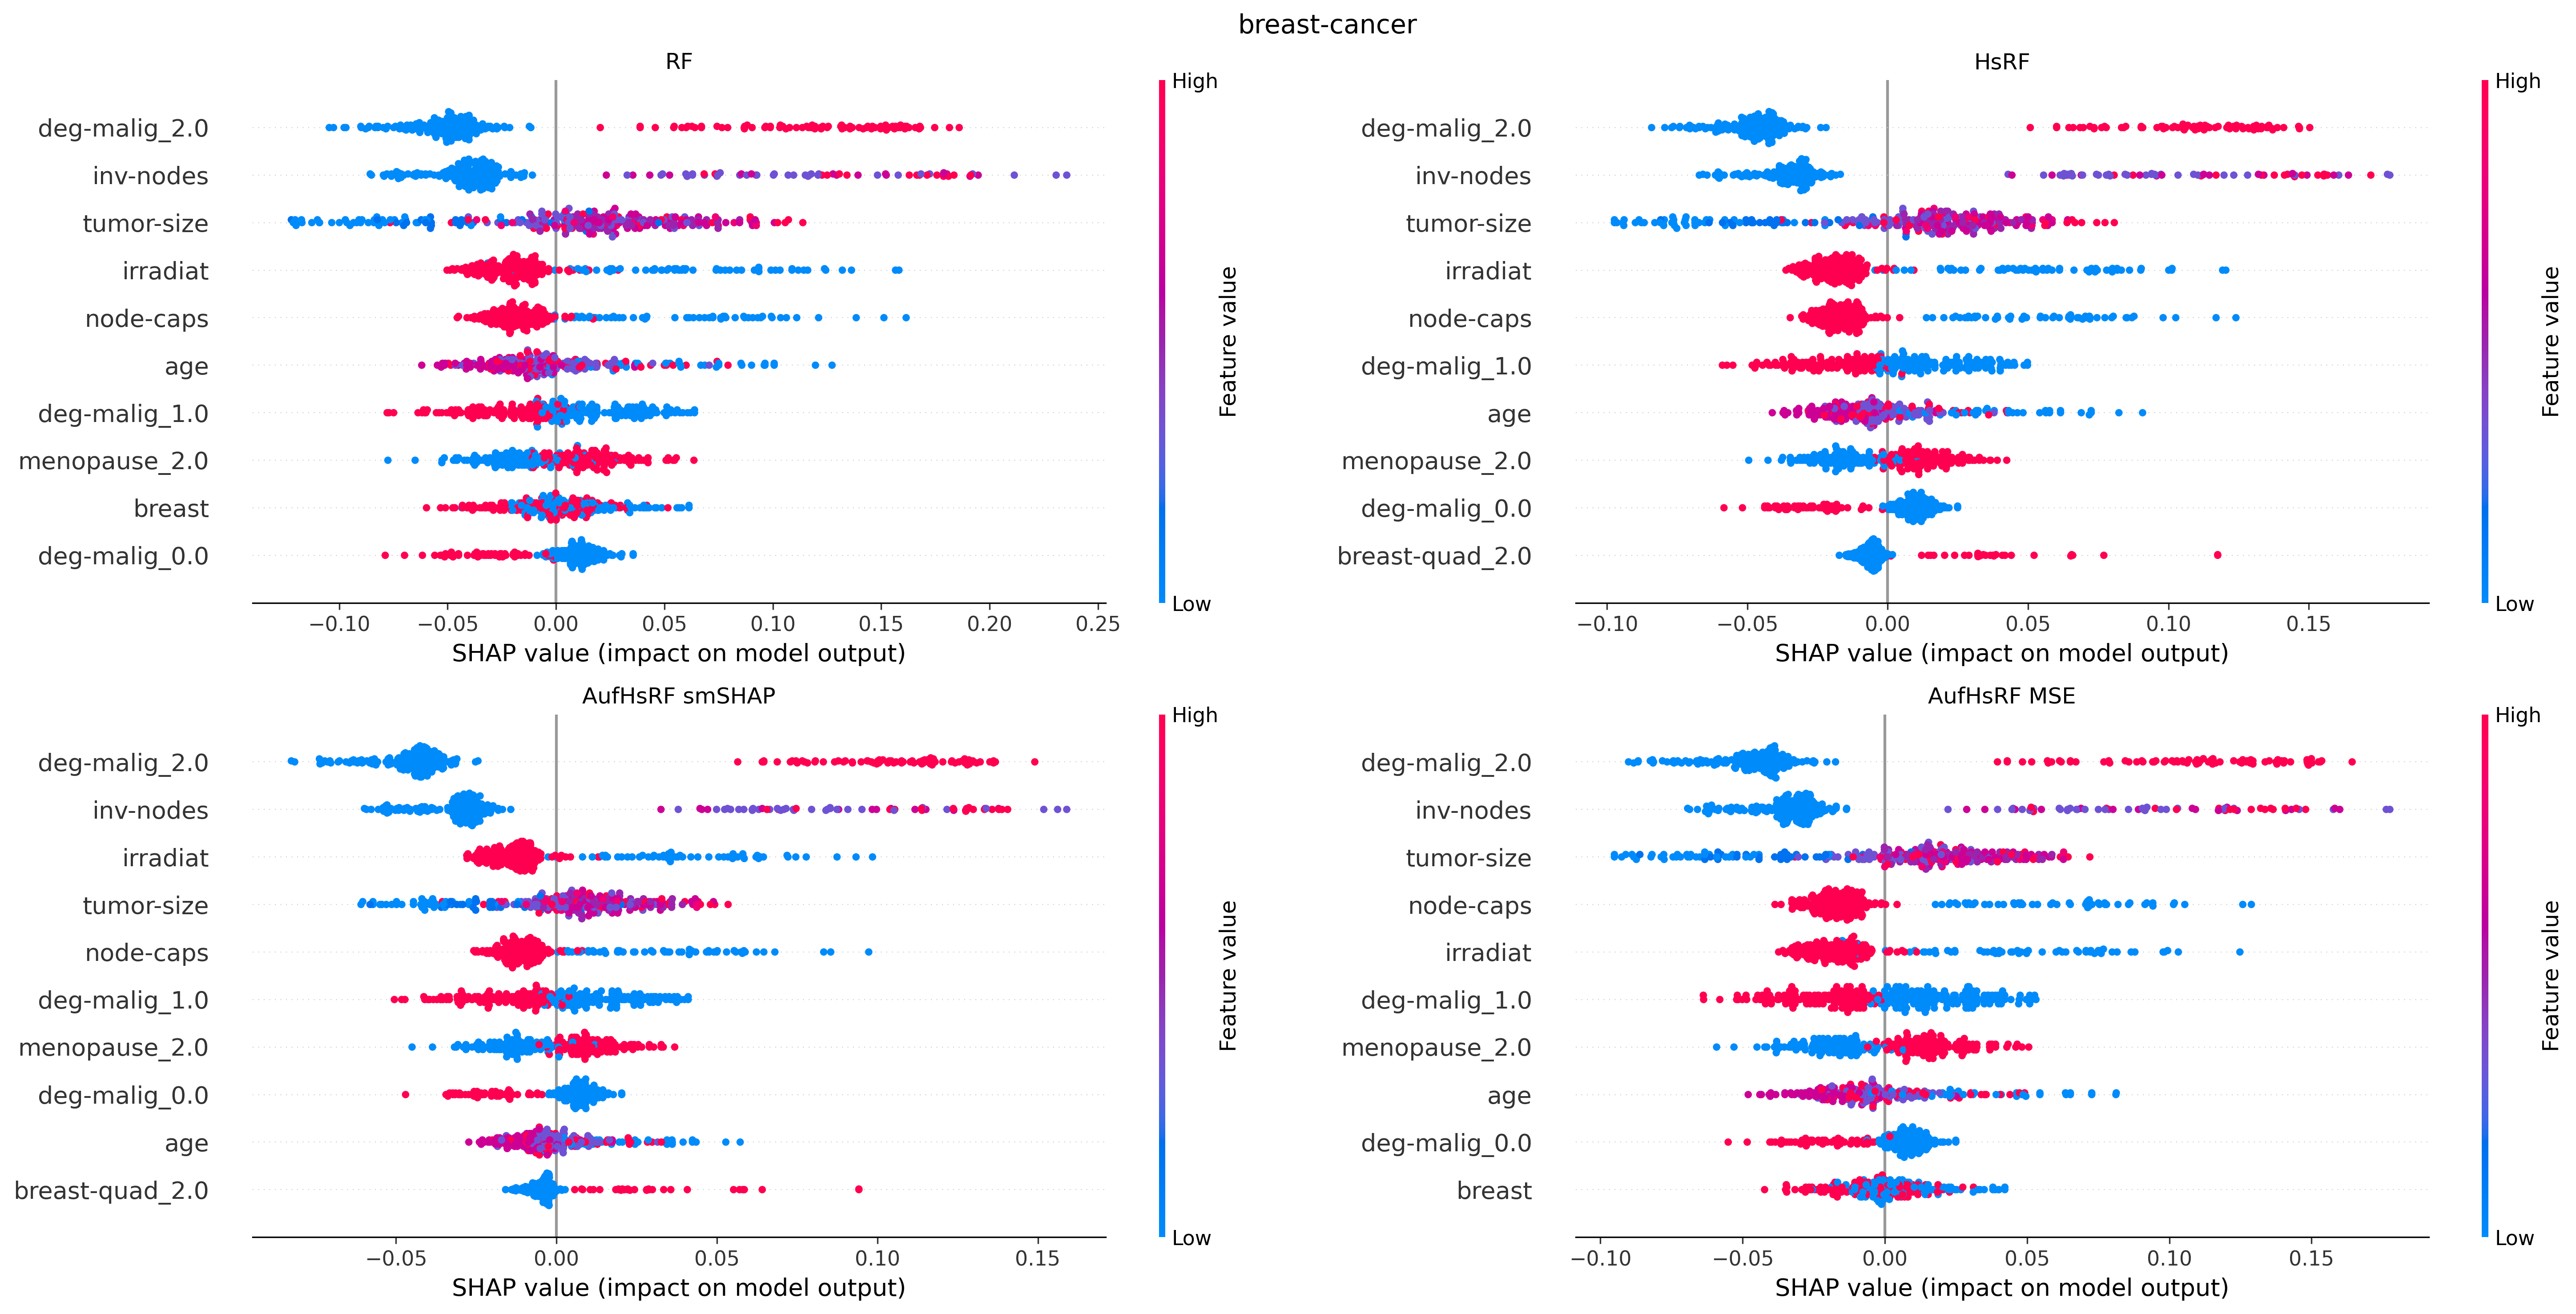

Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


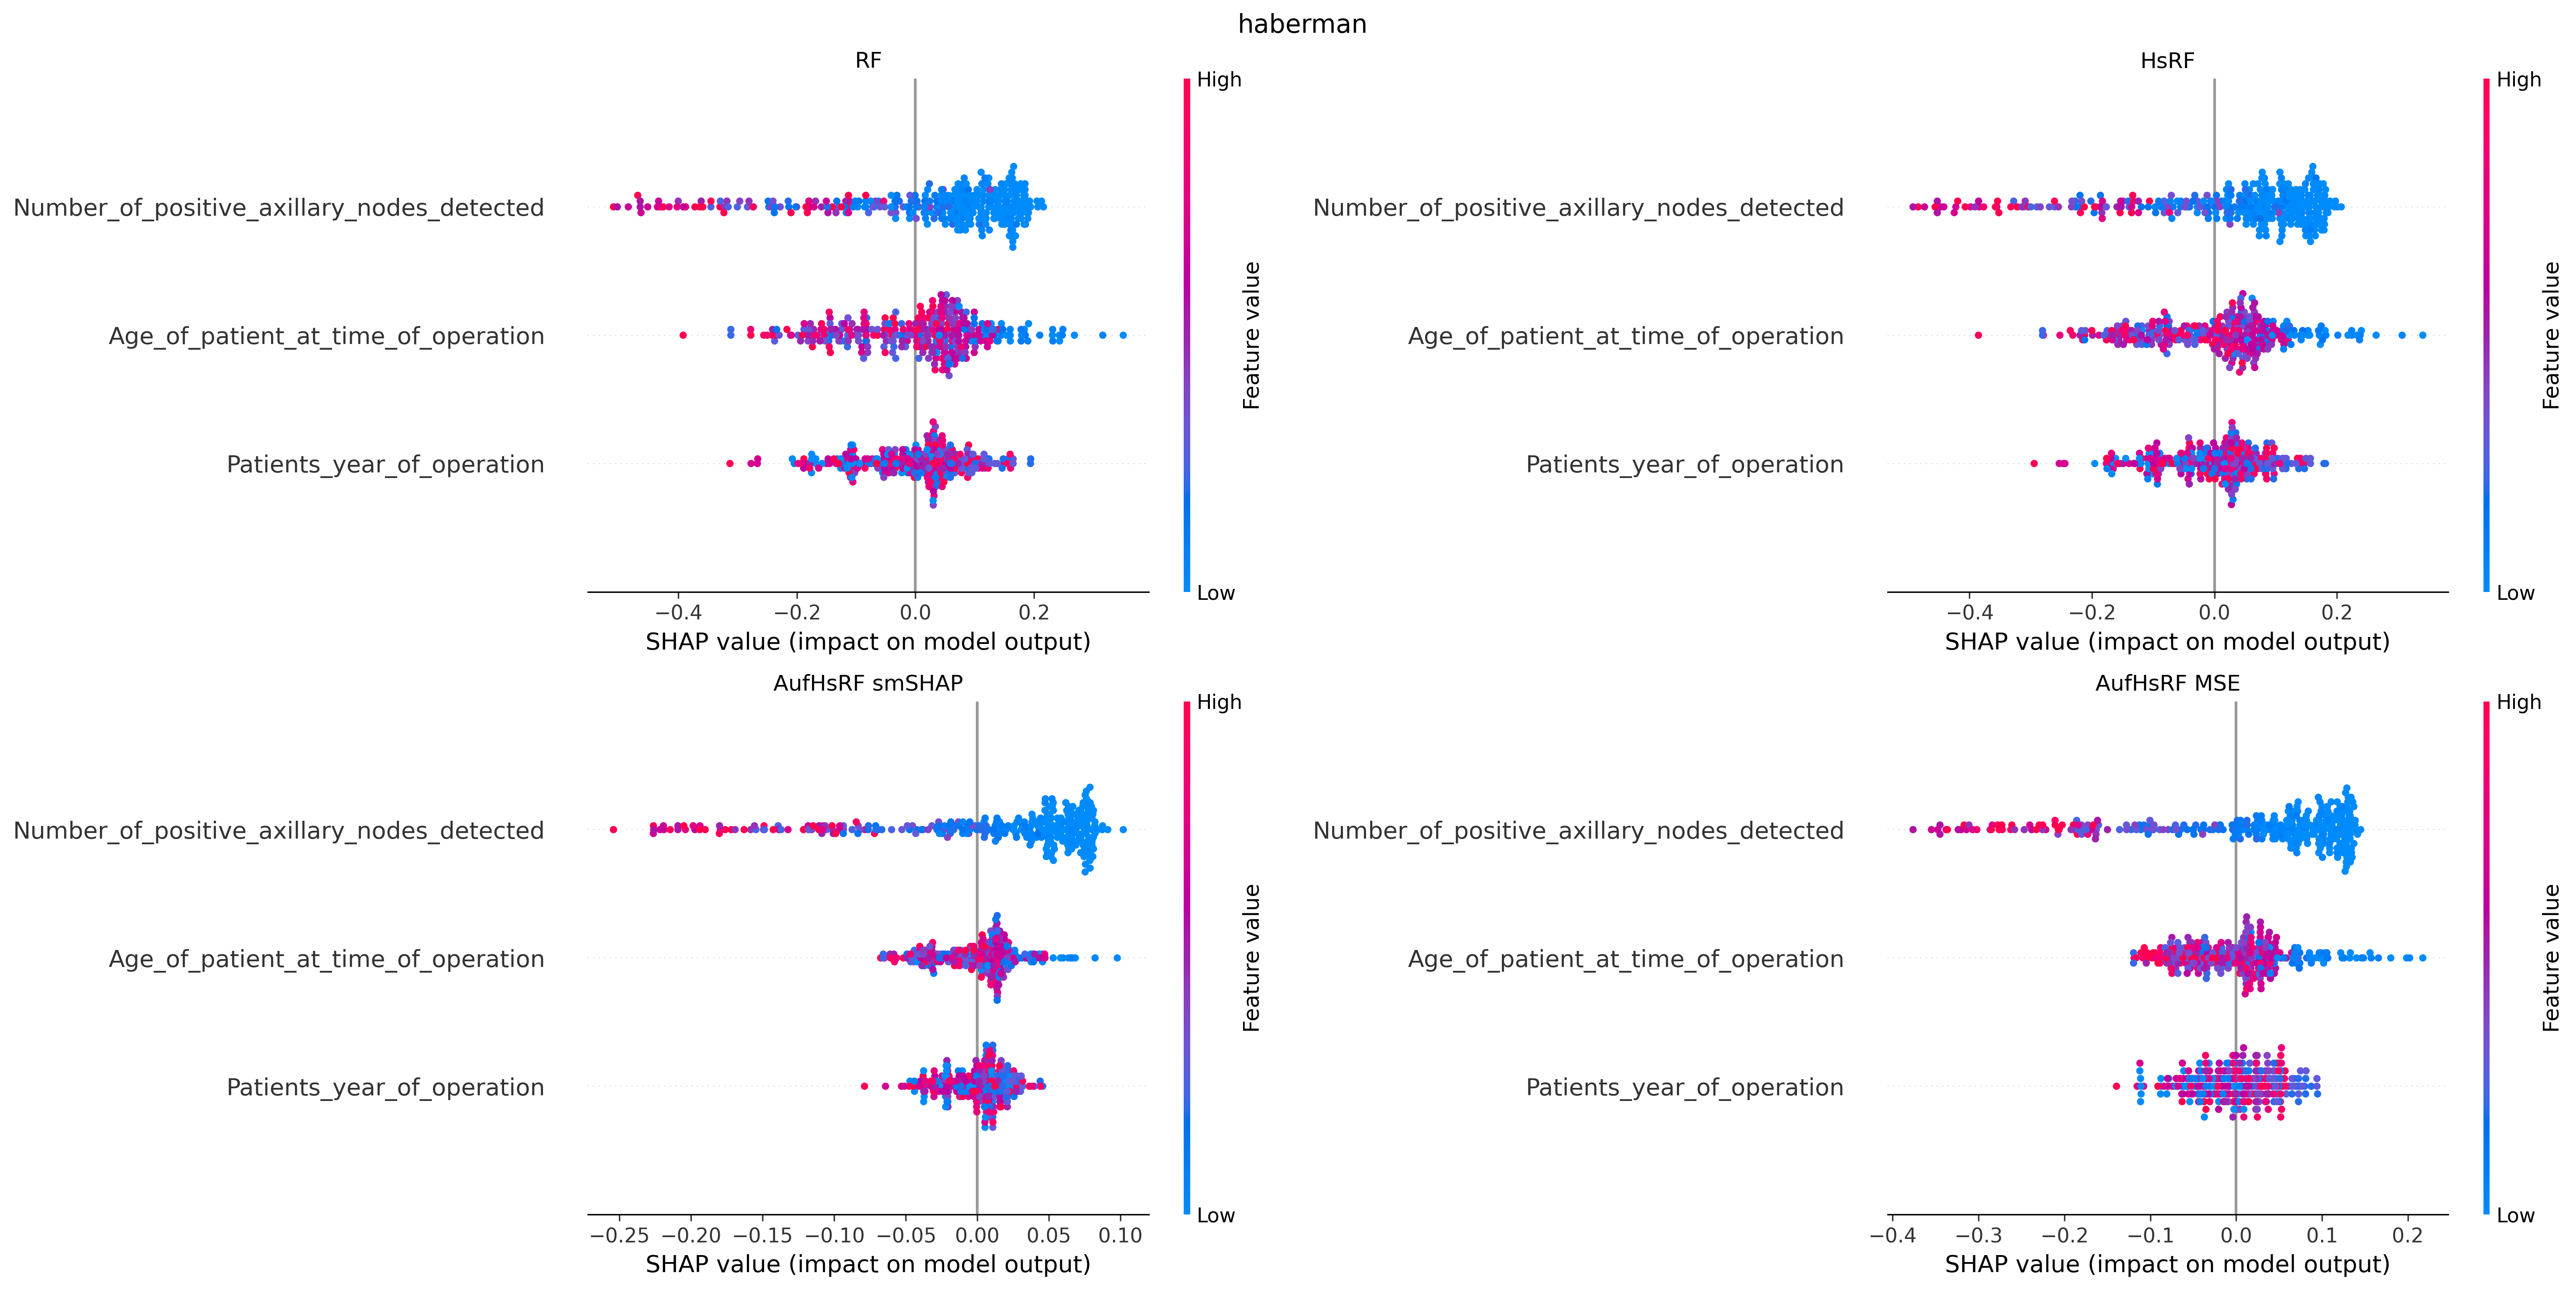

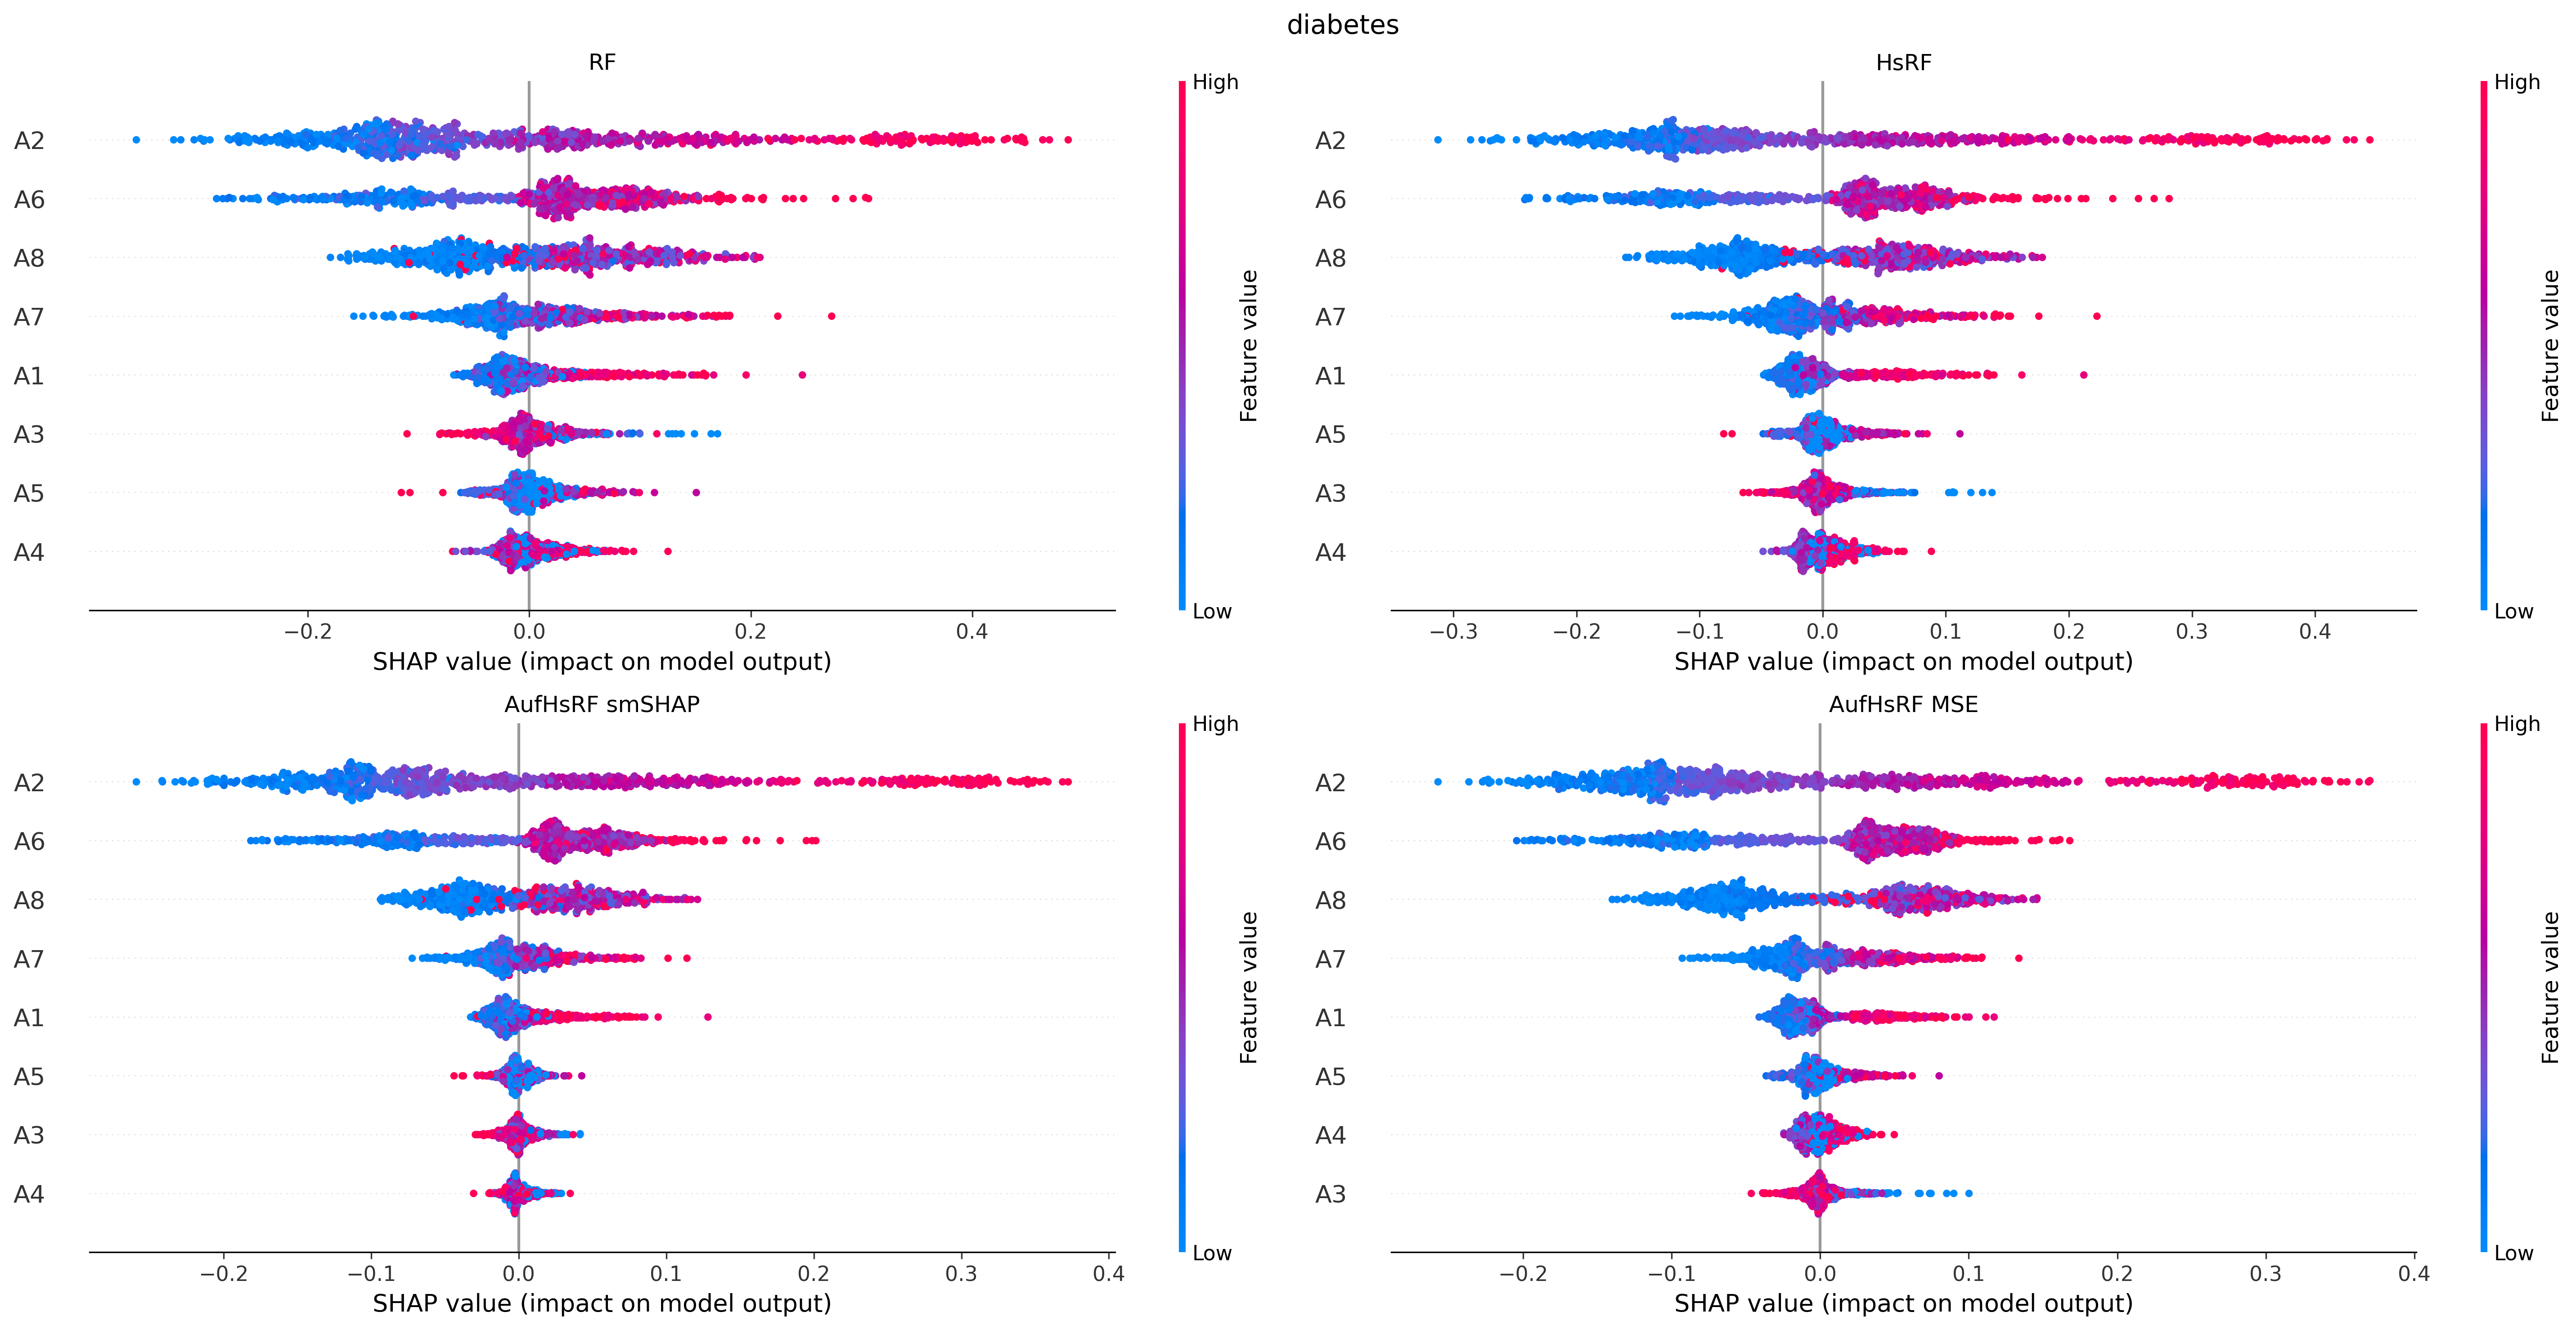

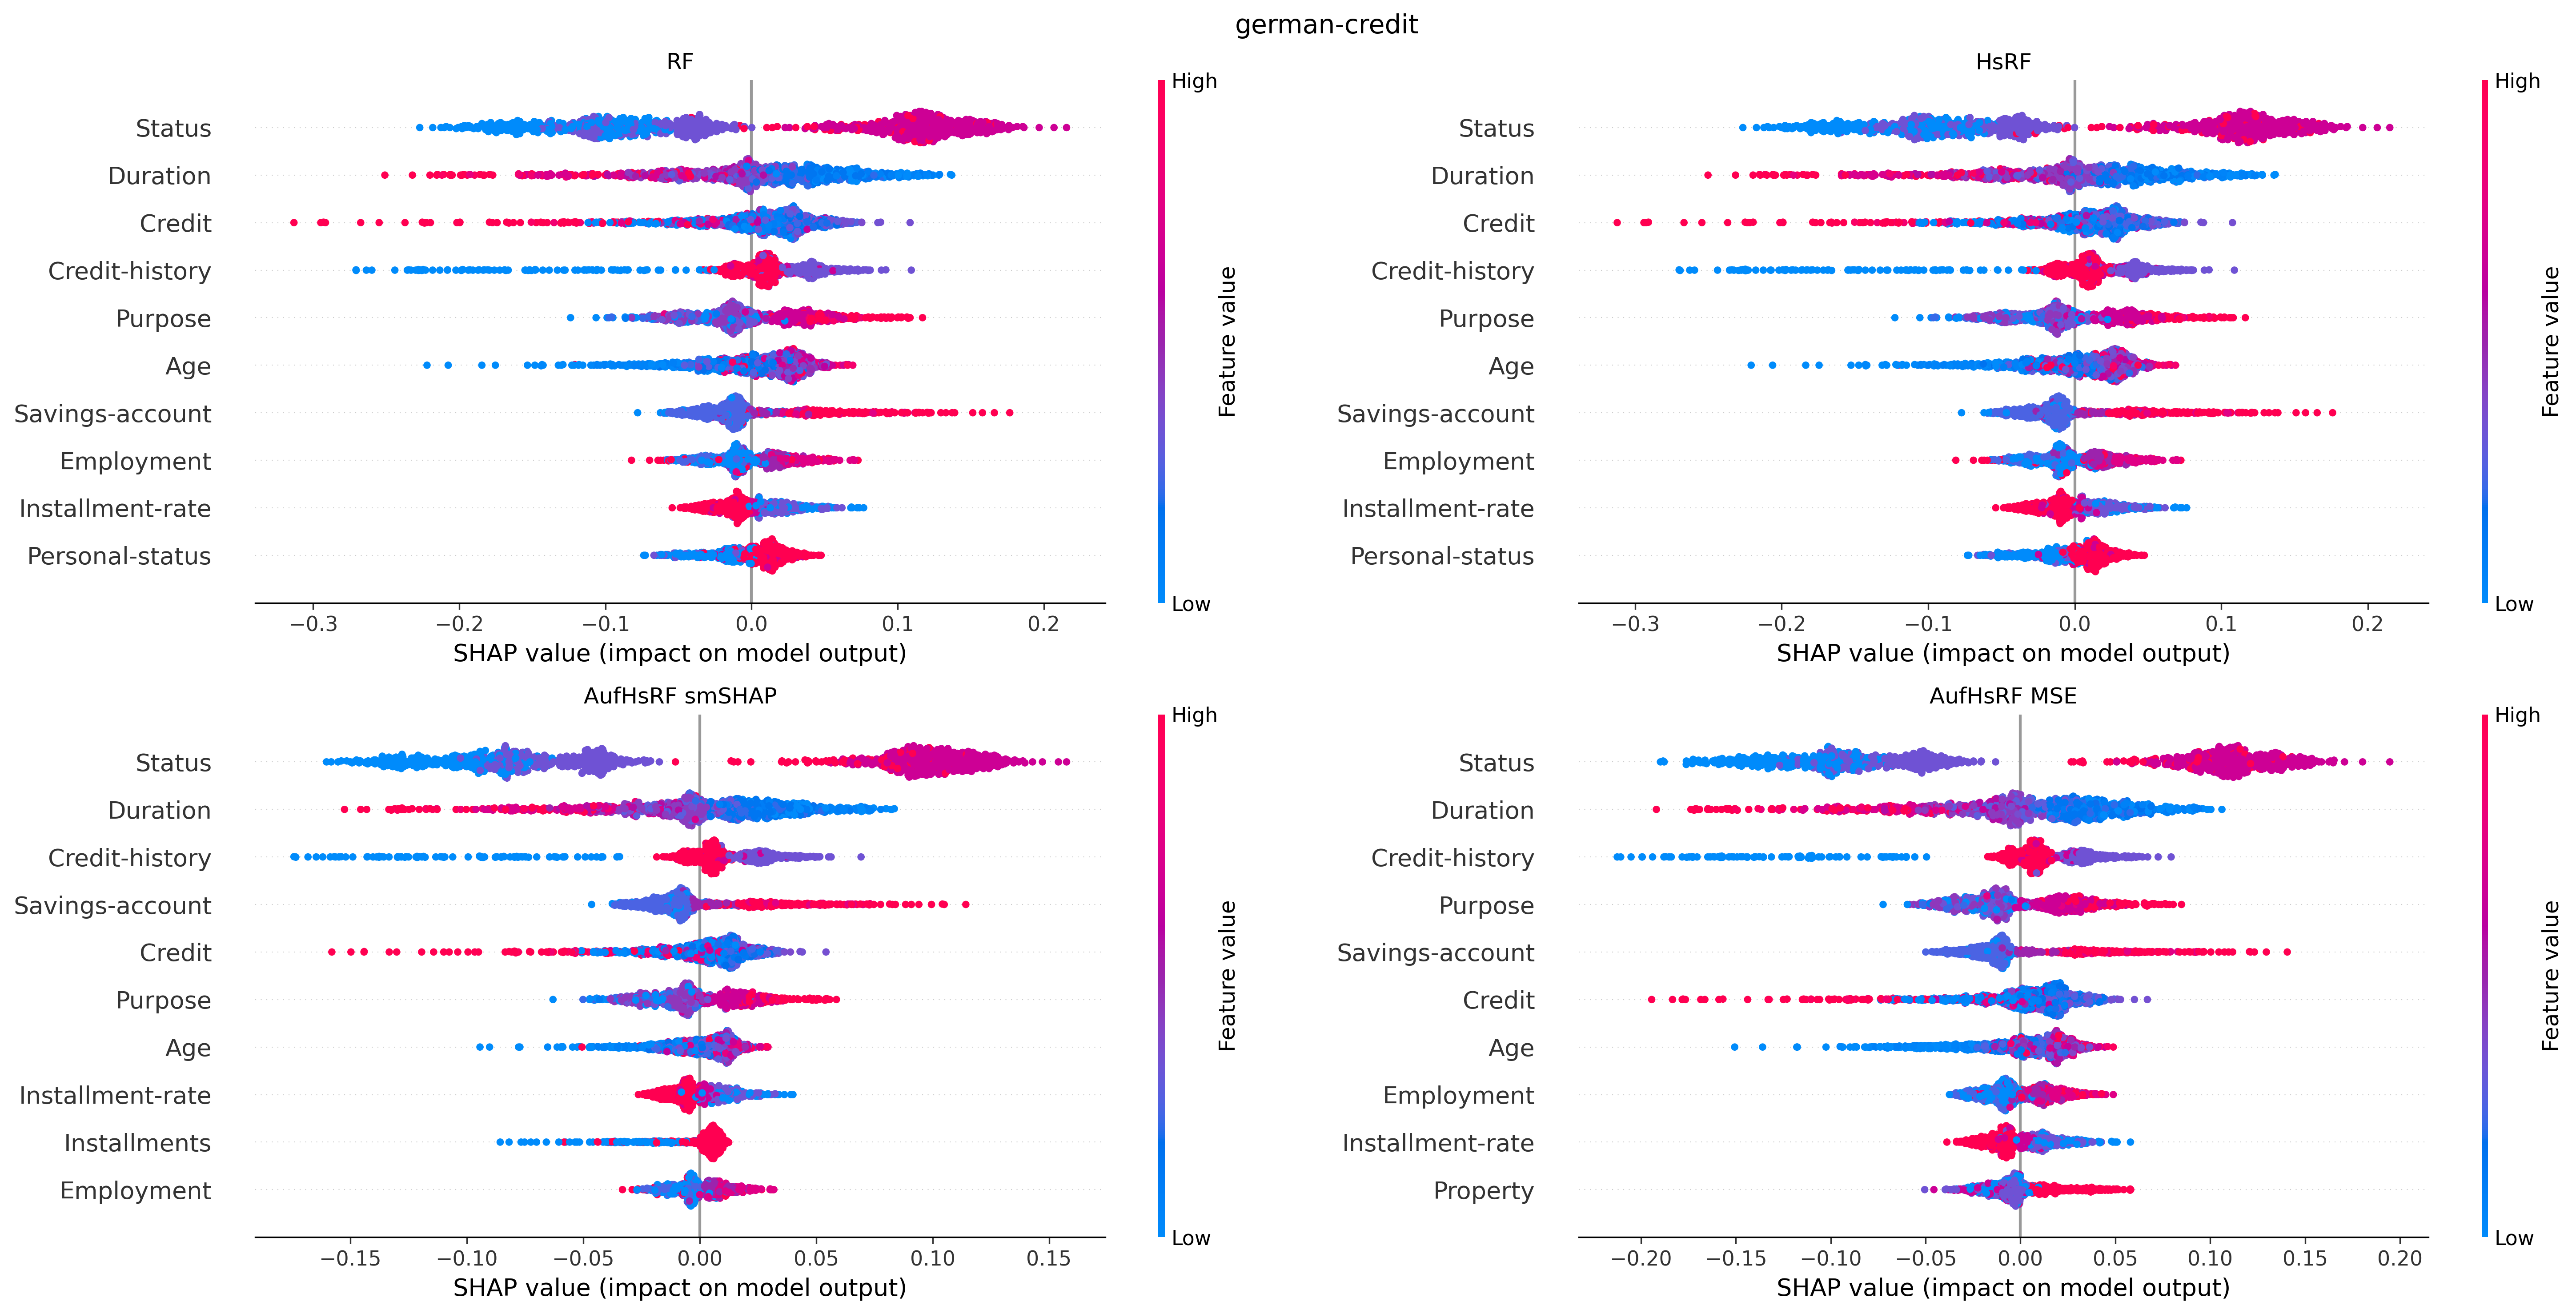

In [71]:
# Create plots for all datasets
for result in results.values():
    fig = create_comp_plot(result)

## Regression datasets

In [72]:
# Run experiment for all reg datasets
reg_num = range(4)
for i in reg_num:
    create_shap_summary_comparison(i, n_estimators=100, treetype="regression", cv=3, random_state=42)

 25%|██▌       | 1/4 [00:49<02:29, 49.82s/it]

In [ ]:
# Load pickeled results
reg_names = ['friedman1','friedman2','friedman3','abalone','diabetes-regr']
results={}

for name in reg_names:
    # load pickeled resutls
    with open(f'{data_path}/{name}_SHAP_dis.pickle', "rb") as input_file:
        results[name]=pickle.load(input_file)

In [ ]:
# Create plots for all datasets
for result in results.values():
    fig = create_comp_plot(result)

6